In [1]:
# Import
import pandas as pd
from finta import TA as ta
from pandas.tseries.offsets import DateOffset
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC
from sklearn.metrics import classification_report
from sklearn.preprocessing import StandardScaler
from pathlib import Path
from sklearn.neighbors import KNeighborsClassifier
import sqlalchemy as sql
from sklearn.ensemble import RandomForestClassifier
import seaborn as sn
import matplotlib.pyplot as plt
from sklearn.ensemble import AdaBoostClassifier

# Setting these options will allow for reviewing more of the DataFrames
pd.set_option('display.max_rows', 2000)
pd.set_option('display.max_columns', 2000)
pd.set_option('display.width', 1000)


In [2]:
tickers = ["BTC","LTC","ETH","ADA","THETA"]
closing_prices_df = pd.DataFrame()
for ticker in tickers:

    ticker1 = ticker
    ticker2 = "USDT"
    
    pair= "{}{}".format(ticker1,ticker2)
    dataframe_name = "df_{}".format(pair)
    start="2019.1.1"
    end = "2022.4.1"
    filepath = "Resources/{}_{}_to_{}.csv".format(pair,start,end)
    dataframe_name = pd.read_csv(Path(filepath), index_col= "Date", parse_dates= True, infer_datetime_format = True)
    if pair == "BTCUSDT":
        df_BTCUSDT = dataframe_name
    elif pair == "LTCUSDT":
        df_LTCUSDT = dataframe_name
    elif pair == "ETHUSDT":
        df_ETHUSDT = dataframe_name
    elif pair == "ADAUSDT":
        df_ADAUSDT = dataframe_name
    elif pair == "THETAUSDT":
        df_THETAUSDT = dataframe_name

    closing_prices_df[pair] = dataframe_name["Close"]
    #display(dataframe_name.head())
    #display(dataframe_name.tail())

In [3]:
#Determine altcoin correlation to BTC.
#Take price data and see if we have a positive or negitive correlation.
display(closing_prices_df.dropna().head())
close_matrix = closing_prices_df.corr()
print(close_matrix)


,BTCUSDT,LTCUSDT,ETHUSDT,ADAUSDT,THETAUSDT
Date,,,,,
2019-04-10 04:00:00,5188.11,87.65,178.70,0.08538,0.12465
2019-04-10 05:00:00,5213.77,88.20,180.12,0.08611,0.12500
2019-04-10 06:00:00,5213.89,88.34,180.45,0.08607,0.12401
2019-04-10 07:00:00,5199.97,87.60,179.08,0.08566,0.12350
2019-04-10 08:00:00,5209.96,87.89,179.45,0.08585,0.12622


            BTCUSDT   LTCUSDT   ETHUSDT   ADAUSDT  THETAUSDT
BTCUSDT    1.000000  0.896537  0.927456  0.890605   0.883011
LTCUSDT    0.896537  1.000000  0.807577  0.808970   0.878418
ETHUSDT    0.927456  0.807577  1.000000  0.929424   0.799544
ADAUSDT    0.890605  0.808970  0.929424  1.000000   0.849501
THETAUSDT  0.883011  0.878418  0.799544  0.849501   1.000000


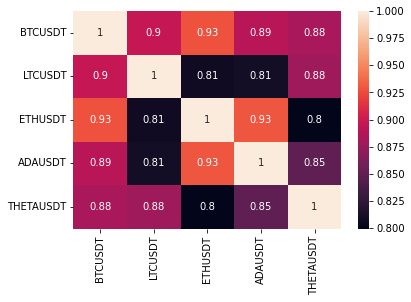

In [4]:
#Create a heat map of the correlation.
sn.heatmap(close_matrix, annot=True)
plt.show()

In [5]:
%whos DataFrame

Variable            Type         Data/Info
------------------------------------------
close_matrix        DataFrame                BTCUSDT   LTC<...>9544  0.849501   1.000000
closing_prices_df   DataFrame                          BTC<...>n[28407 rows x 5 columns]
dataframe_name      DataFrame                            O<...>n[26033 rows x 5 columns]
df_ADAUSDT          DataFrame                            O<...>n[28407 rows x 5 columns]
df_BTCUSDT          DataFrame                             <...>n[28407 rows x 5 columns]
df_ETHUSDT          DataFrame                            O<...>n[28407 rows x 5 columns]
df_LTCUSDT          DataFrame                           Op<...>n[28407 rows x 5 columns]
df_THETAUSDT        DataFrame                            O<...>n[26033 rows x 5 columns]


In [6]:
def appendData(maindf, dataarray, namesarray=None):
    if namesarray==None:
        return maindf.join(pd.DataFrame(dataarray), how='outer')
    return maindf.join(pd.DataFrame(dataarray,columns=namesarray), how='outer')

In [7]:
### Oscillators ###
## RSI
df_BTCUSDT = appendData(df_BTCUSDT,ta.RSI(df_BTCUSDT))
## Sto-%K
df_BTCUSDT = appendData(df_BTCUSDT,ta.STOCH(df_BTCUSDT))
## CCI
df_BTCUSDT = appendData(df_BTCUSDT,ta.CCI(df_BTCUSDT))
## ADX
df_BTCUSDT = appendData(df_BTCUSDT,ta.ADX(df_BTCUSDT))
## DMI (Added to aid in interpreting ADX)
df_BTCUSDT = appendData(df_BTCUSDT,ta.DMI(df_BTCUSDT, 14))
## Awesome
df_BTCUSDT = appendData(df_BTCUSDT,ta.AO(df_BTCUSDT))
## Momentum
df_BTCUSDT = appendData(df_BTCUSDT,ta.MOM(df_BTCUSDT,10))
## MACD (We rename the undescriptive "SIGNAL" here)
## Sto-RSI
df_BTCUSDT = appendData(df_BTCUSDT,ta.STOCHRSI(df_BTCUSDT))
## Williams %R
df_BTCUSDT = appendData(df_BTCUSDT,ta.WILLIAMS(df_BTCUSDT))
## Bull-Bear Power
df_BTCUSDT = appendData(df_BTCUSDT,ta.EBBP(df_BTCUSDT))
## Ultimate (FinTA does not name this column, so we must)
df_BTCUSDT = appendData(df_BTCUSDT,ta.UO(df_BTCUSDT),["UO"])
### Moving Averages ###
sma_ema_averages = [5, 10, 20, 30, 50, 100, 200]
## SMA, EMA
for i in sma_ema_averages:
    df_BTCUSDT = appendData(df_BTCUSDT,ta.SMA(df_BTCUSDT, i))
    df_BTCUSDT = appendData(df_BTCUSDT,ta.EMA(df_BTCUSDT, i))
## VWMA
df_BTCUSDT = appendData(df_BTCUSDT, ta.VAMA(df_BTCUSDT, 20))
## Hull
df_BTCUSDT = appendData(df_BTCUSDT,ta.HMA(df_BTCUSDT, 9))
# Ichimoku -- Base (Kijun) and Conversion (Tenkan) Only
df_BTCUSDT = appendData(df_BTCUSDT,ta.ICHIMOKU(df_BTCUSDT).drop(['senkou_span_a','SENKOU','CHIKOU'], axis=1))


In [8]:
database_connection_string = 'sqlite:///'
engine = sql.create_engine(database_connection_string, echo=True)
sql_statement = """
CREATE TABLE crypto_outcome (
  column_name BLOB,
  _0_precision BLOB,
  _1_precision BLOB,
  _0_recall BLOB,
  _1_recall BLOB,
  _0_f1 BLOB,
  _1_f1 BLOB,
  _0_support BLOB,
  _1_support BLOB,
  _accuracy BLOB
  )
"""
result = engine.execute(sql_statement)

2022-04-11 19:50:33,645 INFO sqlalchemy.engine.Engine 
CREATE TABLE crypto_outcome (
  column_name BLOB,
  _0_precision BLOB,
  _1_precision BLOB,
  _0_recall BLOB,
  _1_recall BLOB,
  _0_f1 BLOB,
  _1_f1 BLOB,
  _0_support BLOB,
  _1_support BLOB,
  _accuracy BLOB
  )

2022-04-11 19:50:33,647 INFO sqlalchemy.engine.Engine [raw sql] ()
2022-04-11 19:50:33,650 INFO sqlalchemy.engine.Engine COMMIT


In [9]:
models_list = [KNeighborsClassifier(n_neighbors=3),SVC(), RandomForestClassifier(), AdaBoostClassifier()]
percent_threshold = .03
investment_amount = 10000
training_length = 12        


for m in models_list:
    model = m
    i = 10
    i_end = 30
    while i <= i_end:
        column_name = str(m) + str(i) + "_period_return"
        df_BTCUSDT[column_name] = df_BTCUSDT["Close"].pct_change(periods=i)
        # Initialize the new `Signal` column
        signal_column_name = str(m) + str(i) + "_signal"
        df_BTCUSDT[signal_column_name] = 0.0
        # Generate signal to buy stock long
        df_BTCUSDT.loc[(df_BTCUSDT[column_name] >= (percent_threshold)), signal_column_name] = 1
        # Drop all NaN values from the DataFrame
        df_BTCUSDT = df_BTCUSDT.dropna()
        y = df_BTCUSDT[signal_column_name]
        # set up X for ml 
        X = df_BTCUSDT[["14 period RSI", "14 period STOCH %K", "20 period CCI", "14 period ADX.", "DI+", "DI-", "AO", "MOM", "14 period stochastic RSI.", "14 Williams %R", "Bull.", "Bear.", "UO", "5 period SMA", "5 period EMA", "10 period SMA", "10 period EMA", "20 period SMA", "20 period EMA", "30 period SMA", "30 period EMA", "50 period SMA", "50 period EMA", "100 period SMA", "100 period EMA", "200 period SMA", "200 period EMA", "20 period VAMA", "9 period HMA.", "TENKAN", "KIJUN"]].shift().dropna().copy()
        y_count = y.value_counts()
        training_begin = X.index.min()
        # Use the following code to select the ending period for the training data: `training_end = X.index.min() + DateOffset(months=3)`
        training_end = X.index.min() + DateOffset(months=training_length)
        # Generate the X_train and y_train DataFrames using loc to select the rows from `training_begin` up to `training_end`
        # Hint: Use `loc[training_begin:training_end]` for X_train and y_train
        X_train = X.loc[training_begin:training_end]
        y_train = y.loc[training_begin:training_end]

        # Generate the X_test and y_test DataFrames using loc to select from `training_end` to the last row in the DataFrame.
        # Hint: Use `loc[training_end:]` for X_test and y_test
        X_test = X.loc[training_end:]
        y_test = y.loc[training_end:]

        # Use StandardScaler to scale the X_train and X_test data.
        scaler = StandardScaler()
        X_scaler = scaler.fit(X_train)
        X_train_scaled = X_scaler.transform(X_train)
        X_test_scaled = X_scaler.transform(X_test)

        # Fit the model to the data using X_train_scaled and y_train
        model = model.fit(X_train_scaled, y_train)

        # Use the trained model to predict the trading signals for the training data.
        training_signal_predictions = model.predict(X_train_scaled)

        # Evaluate the model using a classification report
        training_report_train = classification_report(y_train, training_signal_predictions)
        #print(column_name)
        #print("Training Report")
        #print(training_report_train)

        # Use the trained model to predict the trading signals for the testing data.
        testing_signal_predictions = model.predict(X_test_scaled)

        # Evaluate the model's ability to predict the trading signal for the testing data using a classification report
        #training_report_test = classification_report(y_test, testing_signal_predictions)

        reportdf = pd.DataFrame(classification_report(y_test, testing_signal_predictions, output_dict=True)).transpose()
        
        engine.execute("INSERT INTO crypto_outcome VALUES (?, ?, ?, ?, ?, ?, ?, ?, ?,?)", (column_name, reportdf['precision'][0], reportdf['precision'][1], reportdf['recall'][0], reportdf['recall'][1], reportdf['f1-score'][0], reportdf['f1-score'][1],reportdf['support'][0], reportdf['support'][1], reportdf['precision'][2]))
       
       
        i+=1
    
sql_query = """
SELECT *
FROM crypto_outcome
"""
outcome = pd.read_sql_query(sql_query, engine, index_col='column_name')
outcome


2022-04-11 19:50:59,538 INFO sqlalchemy.engine.Engine INSERT INTO crypto_outcome VALUES (?, ?, ?, ?, ?, ?, ?, ?, ?,?)
2022-04-11 19:50:59,545 INFO sqlalchemy.engine.Engine [raw sql] ('KNeighborsClassifier(n_neighbors=3)10_period_return', 0.974023709902371, 0.5531539479488311, 0.9430066389107685, 0.7372134038800705, 0.9582642501858097, 0.6320564516129032, 17774.0, 1701.0, 0.9250320924261874)
2022-04-11 19:50:59,556 INFO sqlalchemy.engine.Engine COMMIT
2022-04-11 19:51:25,933 INFO sqlalchemy.engine.Engine INSERT INTO crypto_outcome VALUES (?, ?, ?, ?, ?, ?, ?, ?, ?,?)
2022-04-11 19:51:25,934 INFO sqlalchemy.engine.Engine [raw sql] ('KNeighborsClassifier(n_neighbors=3)11_period_return', 0.9856573705179282, 0.5042870752619879, 0.9115179684842988, 0.8715697036223929, 0.9471390287716818, 0.6389056527861597, 17642.0, 1822.0, 0.9077784628031237)
2022-04-11 19:51:25,944 INFO sqlalchemy.engine.Engine COMMIT
2022-04-11 19:51:50,930 INFO sqlalchemy.engine.Engine INSERT INTO crypto_outcome VALUES (

,_0_precision,_1_precision,_0_recall,_1_recall,_0_f1,_1_f1,_0_support,_1_support,_accuracy
column_name,,,,,,,,,
KNeighborsClassifier(n_neighbors=3)10_period_return,0.974024,0.553154,0.943007,0.737213,0.958264,0.632056,17774.0,1701.0,0.925032
KNeighborsClassifier(n_neighbors=3)11_period_return,0.985657,0.504287,0.911518,0.871570,0.947139,0.638906,17642.0,1822.0,0.907778
KNeighborsClassifier(n_neighbors=3)12_period_return,0.973422,0.536072,0.923020,0.779227,0.947551,0.635174,17459.0,1993.0,0.908287
KNeighborsClassifier(n_neighbors=3)13_period_return,0.969941,0.458856,0.885076,0.780352,0.925567,0.577900,17281.0,2158.0,0.873450
KNeighborsClassifier(n_neighbors=3)14_period_return,0.963792,0.263523,0.703090,0.800879,0.813054,0.396561,17150.0,2275.0,0.714543
KNeighborsClassifier(n_neighbors=3)15_period_return,0.960690,0.278618,0.705034,0.797938,0.813243,0.413020,16985.0,2425.0,0.716641
KNeighborsClassifier(n_neighbors=3)16_period_return,0.972319,0.298114,0.683406,0.873599,0.802655,0.444532,16807.0,2587.0,0.708776
KNeighborsClassifier(n_neighbors=3)17_period_return,0.969347,0.308652,0.680226,0.869056,0.799449,0.455521,16643.0,2734.0,0.706869
KNeighborsClassifier(n_neighbors=3)18_period_return,0.966416,0.324540,0.686184,0.863447,0.802541,0.471761,16481.0,2878.0,0.712537


In [10]:
outcome_filtered = outcome[outcome["_1_recall"] > 0.6]
outcome_filtered = outcome_filtered[outcome_filtered["_1_precision"] > 0.6]
 #   _0_precision	_1_precision	_0_recall	_1_recall	_0_f1	_1_f1	_0_support	_1_support	_accuracy

outcome_filtered

,_0_precision,_1_precision,_0_recall,_1_recall,_0_f1,_1_f1,_0_support,_1_support,_accuracy
column_name,,,,,,,,,
RandomForestClassifier()24_period_return,0.949161,0.618652,0.889874,0.789396,0.918562,0.693672,15001.0,3395.0,0.871331
RandomForestClassifier()27_period_return,0.908921,0.605066,0.895778,0.640142,0.902302,0.622110,14661.0,3657.0,0.844743
RandomForestClassifier()29_period_return,0.918176,0.665020,0.905729,0.698676,0.911910,0.681433,14384.0,3853.0,0.861984
RandomForestClassifier()30_period_return,0.913894,0.707108,0.921075,0.687073,0.917470,0.696946,14254.0,3953.0,0.870270
AdaBoostClassifier()23_period_return,0.919603,0.635692,0.919603,0.635692,0.919603,0.635692,14727.0,3250.0,0.868276
AdaBoostClassifier()25_period_return,0.958928,0.615158,0.873574,0.843777,0.914263,0.711555,14459.0,3463.0,0.867816
AdaBoostClassifier()27_period_return,0.941660,0.647639,0.892186,0.781899,0.916255,0.708464,14256.0,3613.0,0.869886
AdaBoostClassifier()28_period_return,0.922442,0.706347,0.923811,0.702329,0.923126,0.704332,14149.0,3692.0,0.877978
AdaBoostClassifier()29_period_return,0.964164,0.642239,0.867342,0.880770,0.913194,0.742825,14021.0,3791.0,0.870200


In [13]:
outcome_transposed = outcome_filtered.transpose()

outcome_transposed

column_name,RandomForestClassifier()24_period_return,RandomForestClassifier()27_period_return,RandomForestClassifier()29_period_return,RandomForestClassifier()30_period_return,AdaBoostClassifier()23_period_return,AdaBoostClassifier()25_period_return,AdaBoostClassifier()27_period_return,AdaBoostClassifier()28_period_return,AdaBoostClassifier()29_period_return,AdaBoostClassifier()30_period_return
_0_precision,0.949161,0.908921,0.918176,0.913894,0.919603,0.958928,0.941660,0.922442,0.964164,0.944945
_1_precision,0.618652,0.605066,0.665020,0.707108,0.635692,0.615158,0.647639,0.706347,0.642239,0.686476
_0_recall,0.889874,0.895778,0.905729,0.921075,0.919603,0.873574,0.892186,0.923811,0.867342,0.896859
_1_recall,0.789396,0.640142,0.698676,0.687073,0.635692,0.843777,0.781899,0.702329,0.880770,0.812096
_0_f1,0.918562,0.902302,0.911910,0.917470,0.919603,0.914263,0.916255,0.923126,0.913194,0.920274
_1_f1,0.693672,0.622110,0.681433,0.696946,0.635692,0.711555,0.708464,0.704332,0.742825,0.744021
_0_support,15001.000000,14661.000000,14384.000000,14254.000000,14727.000000,14459.000000,14256.000000,14149.000000,14021.000000,13913.000000
_1_support,3395.000000,3657.000000,3853.000000,3953.000000,3250.000000,3463.000000,3613.000000,3692.000000,3791.000000,3869.000000
_accuracy,0.871331,0.844743,0.861984,0.870270,0.868276,0.867816,0.869886,0.877978,0.870200,0.878416


In [44]:
if predictions_df["signal"].shift(28).sum() == 1:
    predictions_df["signal"] == 0
print(predictions_df["signal"])

Date
2020-03-20 04:00:00    1.0
2020-03-20 05:00:00    1.0
2020-03-20 06:00:00    1.0
2020-03-20 07:00:00    1.0
2020-03-20 08:00:00    1.0
                      ... 
2022-03-31 20:00:00    0.0
2022-03-31 21:00:00    0.0
2022-03-31 22:00:00    0.0
2022-03-31 23:00:00    0.0
2022-04-01 00:00:00    0.0
Name: signal, Length: 17782, dtype: float64


In [68]:
period = -29

# Create a new empty predictions DataFrame using code provided below.
# Use the pct_change function to generate the returns from "close"
df_BTCUSDT["actual_return"] = df_BTCUSDT["Close"].pct_change()
predictions_df = pd.DataFrame(index=X_test.index)
predictions_df['signal'] = testing_signal_predictions

predictions_df['signal_2'] = predictions_df['signal']
predictions_df['i_start'] = 0
predictions_df['i_finish'] = 0

i = 0
for index, row in predictions_df.iterrows():
    predictions_df.at[index, 'i_start'] = i
  #  if i == 0 and index == predictions_df.index[0]:
  #      predictions_df.at[index, 'signal_2'] = 1
        
    if row['signal'] == 1:
        if i == 0: 
            row["signal_2"] = row["signal"]
            i += 1
        elif i < 29:
            row["signal_2"] = 0
            i += 1
        elif i == 29:
            row["signal_2"] = row["signal"]
            i = -1
    elif row['signal'] == 0:
        predictions_df.at[index, 'signal_2'] = 0
        i += 1
    
    predictions_df.at[index, 'i_finish'] = i
    
#predictions_df["signal_shift"] = predictions_df["signal"].shift(28)

    
#predictions_df['signal'].value_counts()
predictions_df["29_period_return"] = df_BTCUSDT["Close"].pct_change(periods=period)
# #predictions_df["RandomForestClassifier()29_period_return"] = outcome_transposed["RandomForestClassifier()29_period_return"]


# intial_investment = 10000
# # Add in actual returns and calculate trading returns
# #predictions_df['actual_return'] = df_BTCUSDT['actual_return']
# predictions_df['algo_RFC_29'] = predictions_df.loc[predictions_df["signal"]==1]["29_period_return"]
# #predictions_df['trading_algorithm_returns_3'] = predictions_df.loc[predictions_df["signal"]==1]["3_period_return"]
# predictions_df["algo_RFC_29"].fillna(0, inplace=True)
# #predictions_df["algo_RFC_29_cumulative"] = 
# #predictions_df["algo_RFC_29_cumulative"] = #predictions_df["algo_RFC_29"] + predictions_df["algo_RFC_29"].shift(1) + 1
# #(1 + predictions_df["algo_RFC_29"]).cumprod() - 1
# predictions_df["trading_algo_returns_3_+1_1"] = 1 + predictions_df["algo_RFC_29"]
# predictions_df["trading_algo_returns_3_+1_2"] = (1 + predictions_df["algo_RFC_29"]).cumprod()
# predictions_df["trading_algo_returns_3_+1_3"] = (1 + predictions_df["algo_RFC_29"]).cumprod() - 1
# we need to add trading algo cumulative returns in order to plot agaisnt actual returns and see how well our algo performed compared to actual returns

predictions_df.head(300)

,signal,signal_2,i_start,i_finish,29_period_return
Date,,,,,
2020-03-20 04:00:00,1.0,1.0,0,1,0.037387
2020-03-20 05:00:00,1.0,1.0,1,2,0.040872
2020-03-20 06:00:00,1.0,1.0,2,3,0.019821
2020-03-20 07:00:00,1.0,1.0,3,4,0.030682
2020-03-20 08:00:00,1.0,1.0,4,5,0.071455
2020-03-20 09:00:00,1.0,1.0,5,6,0.092809
2020-03-20 10:00:00,1.0,1.0,6,7,0.098545
2020-03-20 11:00:00,1.0,1.0,7,8,0.085794
2020-03-20 12:00:00,1.0,1.0,8,9,0.090122
